    If you have some background in machine learning and you'd like to learn how to quickly improve the quality of your models, you're in the right place! In this course, you will accelerate your machine learning expertise by learning how to:

    tackle data types often found in real-world datasets (missing values, categorical variables),
    design pipelines to improve the quality of your machine learning code,
    use advanced techniques for model validation (cross-validation),
    build state-of-the-art models that are widely used to win Kaggle competitions (XGBoost), and
    avoid common and important data science mistakes (leakage).

# Missing Values
## Uma opção simples: Drop Columns com missing values
    A opção mais simples é a drop columns. A não ser que a maioria dos valores nas colunas que serão dropadas estejam nulos, o modelo pode perder acesso a muita informação que poderá ser importante para sua modelagem. Em um exemplo extremo, imagine um dataset com 10.000 linhas, se UM dado da coluna esteja missing você perderá a coluna INTEIRA
    
## Uma opção melhor: Imputation
    Imputation é baseada em inserir números no lugar dos missing values. Por exemplo, podemos preencher com a média dos valores ao longo de cada coluna. A imputação dos valores não será exato na maioria dos casos, mas usualmente poderá levar para modelos com maior acurácia do que apenas dropar as colunas.
    
## Extensão da imputation
    Imputation é a maneira padrão de preencher missing values e geralmente funciona bem. Entretanto, os valores podem ser sistematicamente acima ou abaixo do que eles de fato são (que não foram coletadas no dataset). As linhas com missing values podem ser unicas e necesse caso, o seu lado irá funcionar melhor identificado quais valores eram originalmente missing. 
    Nessa abordagem, imputadores os missing values como antes e, adicionalmente, para cada columa com missing values em sua entrada no dataset original, iremos adicionar uma nova columa que mostra o LOCAL em que foi preenchido (que antes era um missing). Em alguns casos isso irá melhorar os resultados consideravelmente, em outros casos não ajuda em nada.
    
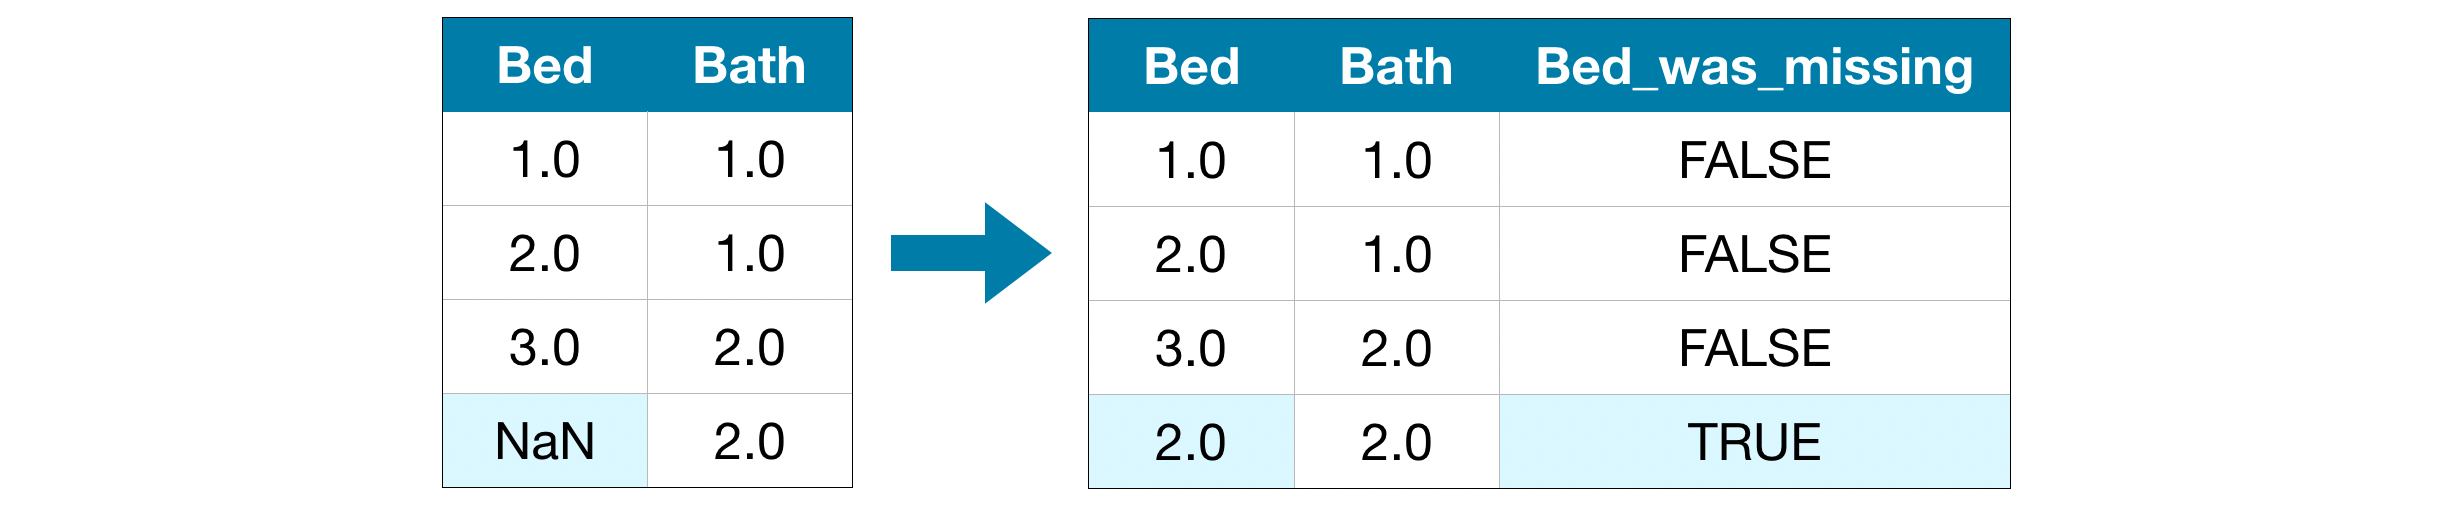

### Exemplo 01: 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('melb_data.csv')

# Select target
y = data.Price

# To keep things simple, we'll use only numerical predictors
melb_predictors = data.drop(['Price'], axis=1)
X = melb_predictors.select_dtypes(exclude=['object'])

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [2]:
# Definiremos uma função chamada score_dataset() que compara diferentes abordagens para lidar com missing values.
# Essa função reporta o Mean Absolute Error (MAE) a partir de uma random forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

**Score da abordagem nº 01: Drop columns com missing values**
    
    Como estamos trabalhando com treino e validação, teremos cuidado para dropar as mesmas colunas em ambos DataFrames

In [3]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop columns with missing values):
183550.22137772635


**Score da abordagem nº 02: Imputation**
    
    Agora usaremos 'SimpleImputer' para substituir os missing values com a media dos valores ao longo da sua coluna. Embora seja simples, poderá trazer resultados satisfatórios a depender do dataset. Embora os estatísticos tenham experimentado maneiras mais complexas de determinar valores imputados (como imputação de regressão, por exemplo), as estratégias complexas normalmente não oferecem nenhum benefício adicional quando você conecta os resultados a modelos sofisticados de aprendizado de máquina.

In [4]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer() #inserir o Simple Imputer em uma variável #strategy(default = 'mean')

# As respostas abaixo vem como um numpay array, por isso iniciamos já transformando em Dataframe (treino e transformo/imput)

imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train)) # Fit (treino) e transformo as features X_train
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))     # Transformo as features de validação X_valid

#my_imputer.fit(X_train)
#imputed_X_train = my_imputer.transform(X_train)
#knn imputer
#O teste só recebe o que aprendeu no treino

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns 
imputed_X_valid.columns = X_valid.columns

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid)) #MAE dos dados que já foram imputados os missing val.


MAE from Approach 2 (Imputation):
178166.46269899711


**Score da abordagem nº 03: Extensão do Imputation**
    
    Agora imputaremos os missing values enquanto também iremos rastrear quais valores foram imputados

In [5]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()
    
# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

MAE from Approach 3 (An Extension to Imputation):
178927.503183954


**Conclusão: Como na maioria dos casos, imputar valores nos missing (abordagem 2 e 3) trouxe melhores resultados quando comparados a simplesmente drop columns com os missing values (abordagem 1).**

# Categorical Variables
    Uma variável categorica recebe apenas um limitado número de valores.
    A primeira coisa a entender é: Algoritmos de Machine Learning NÃO ENTENDEM TEXTOS, apenas números.
    
    1. Considere uma pesquisa que pergunta com que frequência você come o seu café da manhã e fornece as alternativas: Nunca, raramente, a maioria dos dias ou todo dia. Nesse caso, esse dado é categorico, pois a resposta cai em um conjunto fixo de categorias.
    2. Se as pessoas responderem uma pesquisa sobre que marca do carro eles possuem, a resposta irá cair em categorias como "Honda", 'Toyota' e 'Ford'. Nesse caso também é variável categorica.
    
    Você retornará um erro se tentar inserir essas variaveis na maioria dos modelos de Machine Learning em Python sem pré processa-los primeiro. Nesse tutorial iremos comparar três abordagens que poderá ser utilizada para preparar um dado categorico

## Drop Categorical Variabels:
    A maneira mais facil de lidar com as variaveis categoricas é simplesmente as removendo do dataset. Essa abordagem só irá funcionar caso as colunas não contenham informações úteis.
    
## Ordinal Encoding:
    Ordinal encoding designa para cada valor único um número inteiro diferente. 
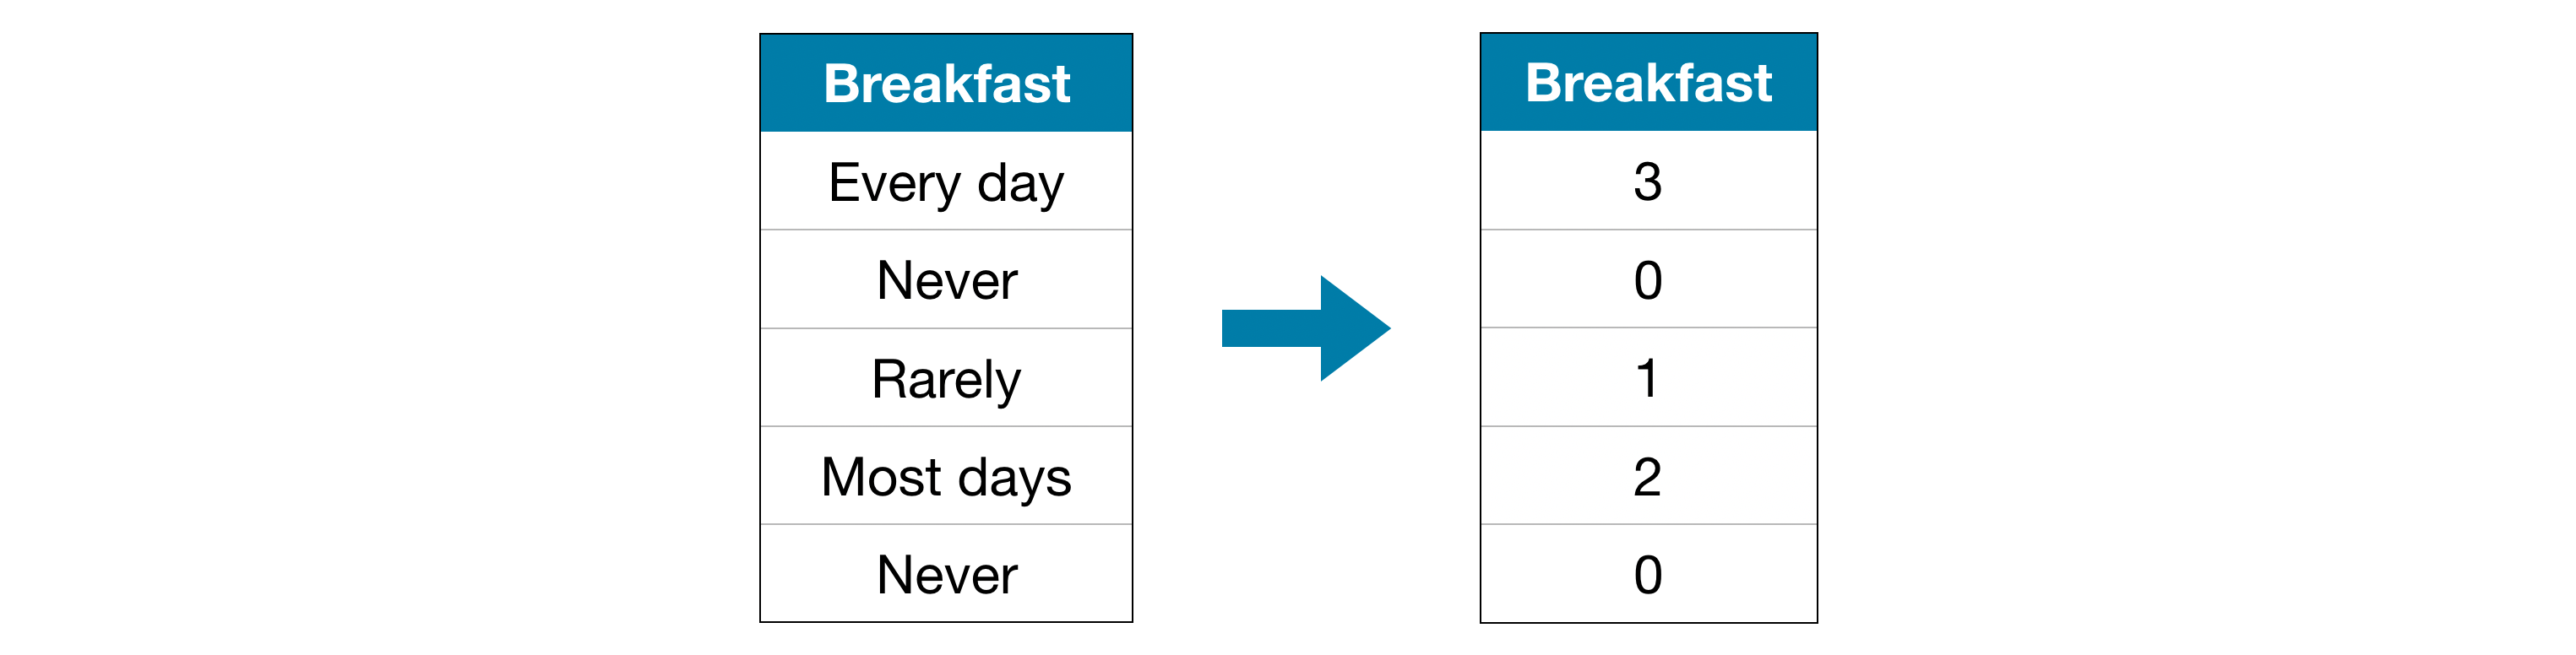
    
    Essa abordagem assume uma ordem das categorias: 'Nunca(0) < Raramente (1) < Maioria dos dias (2) < Todo dia (3).
    Essa suposição de ordem faz sentido nesse exemplo pois há uma classificação indiscutível entre as categorias. Nem todas as variáveis categorias possuirão uma ordem clara de valores, mas nos referimos a essas que tem como "Ordinal Variables". Para 'tree-based models' (Decision trees and random forests) você pode esperar que ordinal encoding irá funcionar bem com as variaveis categoricas.
    Obs: Ordinal Encoding irá ordenar em ORDEM ALFABÉTICA as variáveis números que irão substituir o texto

## One-Hot Encoding
    O one-hot encoding cria novas colunas indicando a presença (ou ausência) para cada valor possivel no dado original.
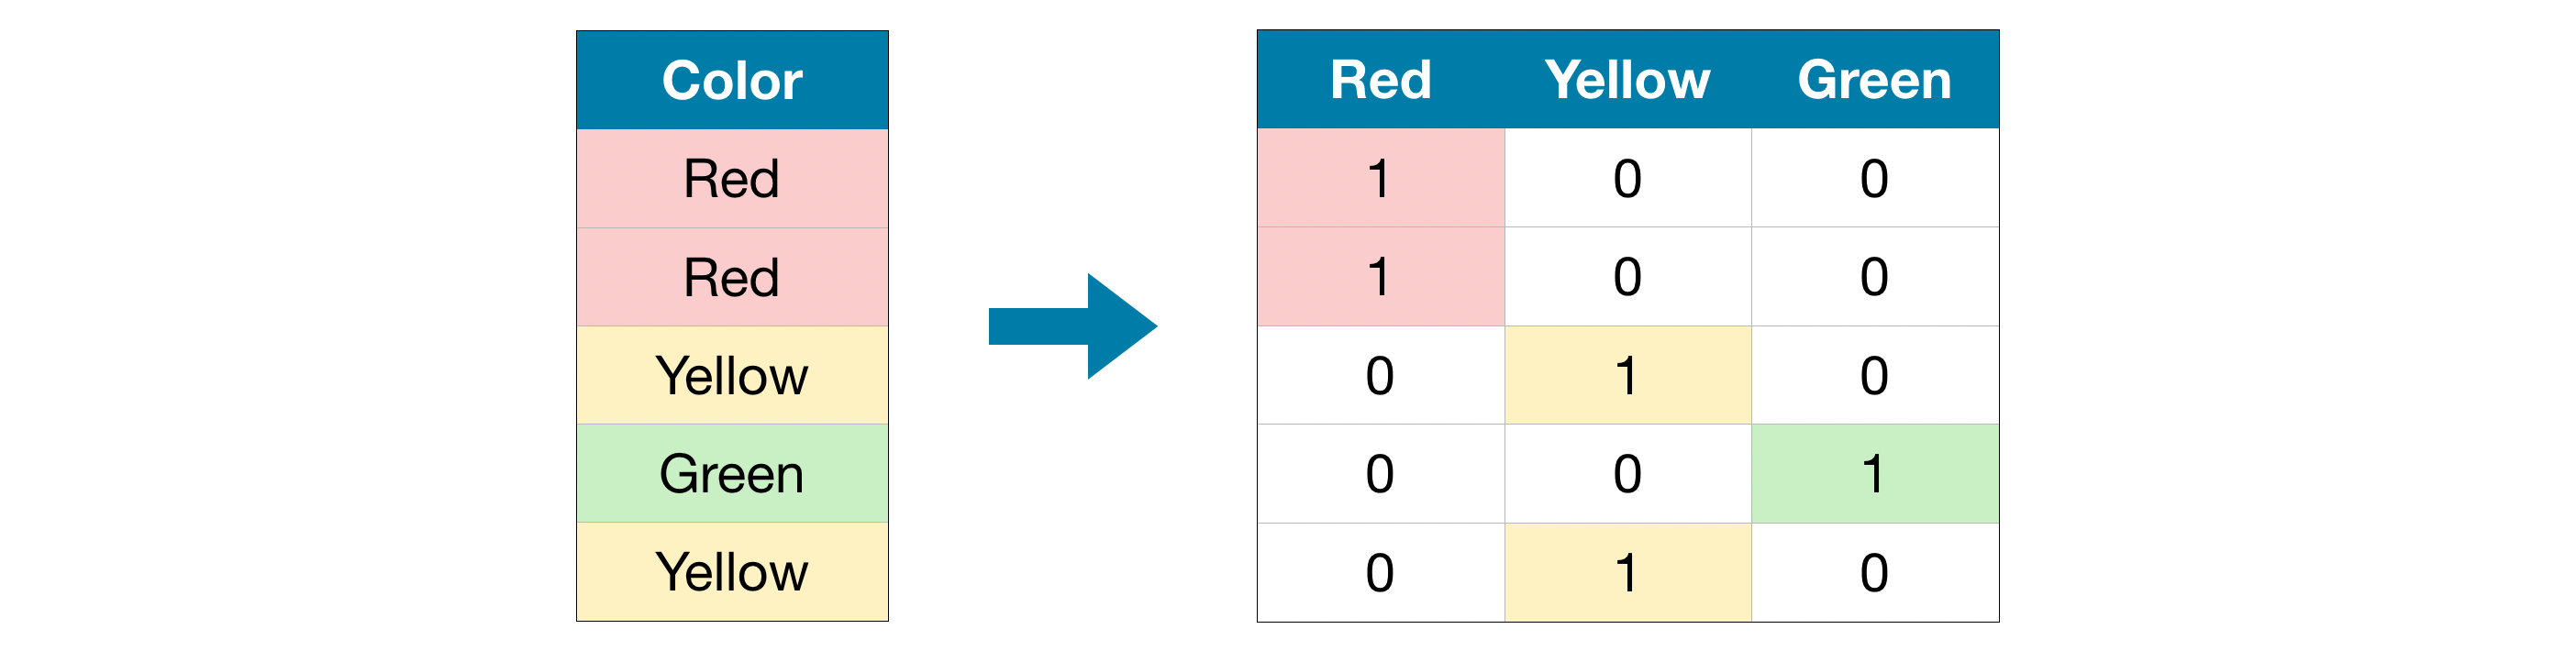

    A imagem acima mostra que cor possui três variaveis categoricas: 'red', 'yellow' and 'green'. A codificação one-hot correspondente contém uma coluna para cada valor possível e uma linha para cada linha no conjunto de dados original. Onde quer que o valor original fosse "Vermelho", colocamos um 1 na coluna "Vermelho"; se o valor original era "Amarelo", colocamos 1 na coluna "Amarelo" e assim por diante.

    Em contraste com a codificação ordinal, a codificação one-hot não assume uma ordenação das categorias. Assim, você pode esperar que essa abordagem funcione particularmente bem se não houver uma ordenação clara nos dados categóricos (por exemplo, "Vermelho" não é nem mais nem menos que "Amarelo"). Referimo-nos a variáveis ​​categóricas sem uma classificação intrínseca como variáveis ​​nominais.

    A codificação one-hot geralmente não funciona bem se a variável categórica assumir um grande número de valores (ou seja, você geralmente não a usará para variáveis com mais de 15 valores diferentes).
    
    Em resumo: One-hot encoding elimina a coluna original e cria novas colunas para cada variável categorica e coloca TRUE (1) or FALSE (O). Sem ordem pre definida, cabendo ao modelo definir a ordenação de importância e peso

**Exemplo 01**

In [6]:
# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)

low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                       X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

<ipython-input-6-37c542c16315>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_full.drop(cols_with_missing, axis=1, inplace=True)
<ipython-input-6-37c542c16315>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_full.drop(cols_with_missing, axis=1, inplace=True)


In [7]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Type', 'Method', 'Regionname']


**Abordagem 01: Drop categorical variabels:**

In [8]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
183550.22137772635


**Abordagem 02: Ordinal encoding:**

In [9]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
175062.2967599411


**Abordagem 03: One-hot encoding**
            
    Primeiramente, utilizamos o 'onehot encoder' class from scikit-learn para obter one hot encodings. Serão números de parâmetros que poderão ser utilizados para costumizar seu comportamento.
    -> Inserimos 'handle_unknown = 'ignore' para evitar erros quando os dados de validação contêm classes que não são representados nos dados de treino
    -> Setamos 'sparse = False' para garantir que as columas encoded's serão retornadas como um numpy array (ao invés de uma matriz).
    
    Para utilizar o encoder, fornecemos apenas as colunas categóricas que pretendemos que sejam codificadas com one hot encodedo. Por exemplo, para codificar os dados de treino, fornecemos X_train[object_cols]. (object_cols na célula de código abaixo é uma lista dos nomes das colunas com dados categóricos, e por isso X_train[object_cols] contém todos os dados categóricos no conjunto de treino).

In [10]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to original dataframe
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)


print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):
176703.63810751104


# Pipelines 
    Pipelines é um jeito simples de manter os dados processando e modelando um código organizado. Especificamente, um pipeline agrupa as etapas de pré-processamento e modelagem para que você possa usar todo o pacote configurável como se fosse uma única etapa. 
    Alguns benefícios de se utilizar o pipeline:
    1. Código mais clean: A contabilização de dados em cada etapa do pré-processamento pode ficar confusa. Com um pipeline, você não precisará acompanhar manualmente seus dados de treinamento e validação em cada etapa.
    
    2. Menos 'bugs': Há menos oportunidades de aplicar incorretamente uma etapa ou esquecer uma etapa de pré-processamento
    
    3. Fácil colocar em produção: Pode ser surpreendentemente difícil fazer a transição de um modelo de protótipo para algo implantável em escala. Não entraremos em muitas preocupações relacionadas aqui, mas os pipelines podem ajudar.
    
    4. Mais opção para validação do modelo: Você verá um exemplo no próximo tutorial, que aborda a validação cruzada.

**Exemplo 01**

In [11]:
# Processo básico -> Lê os dados / Separa as features da target / Divide em treino e validação / Separa colunas categ e num /
                    #Manter apenas as colunas selecionadas para se trabalhar.
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols

X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()


In [12]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,1.0,0.0,NaN,1940.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,1.0,193.0,NaN,NaN,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,1.0,555.0,NaN,NaN,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,1.0,265.0,NaN,1995.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,2.0,673.0,673.0,1970.0,-37.76230,144.8272,4217.0


**Iremos construir o pipeline em 03 passos:**
    
       Passo 01. Definição dos passos de pré-processamento: Similar a como um pipeline agrupa as etapas de modelagem, utilizaremos a classe ColumnTransformer paara agrupar diferentes etapas. 
    Sendo assim:
    1.1 Imputar os missing values nos dados numericos e
    1.2 Imputar os missing values e aplicar one-hot encoder nos dados categoricos:        

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing dos dados numericos
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing dos dados categoricos -> 
# The Pipeline is built using a list of (key, value) pairs, 
# where the key is a string containing the name you want to give this step and value is an estimator object:

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')), #key, value
                                         ('onehot', OneHotEncoder(handle_unknown='ignore'))])   #key, value
 
# Pacote de pré-processamento das variaveis numericas e categoricas
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                                ('cat', categorical_transformer, categorical_cols)])

In [14]:
# As features numericas e categoricas foram separadas no código anterior, veja abaixo como fica o 'preprocessor':
preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='constant'),
                                 ['Rooms', 'Distance', 'Postcode', 'Bedroom2',
                                  'Bathroom', 'Car', 'Landsize', 'BuildingArea',
                                  'YearBuilt', 'Lattitude', 'Longtitude',
                                  'Propertycount']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Type', 'Method', 'Regionname'])])

**Passo 02: Definição do modelo de machine learning**

In [15]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

**Passo 03: Criar e avaliar o Pipeline**
        
    Por fim, utiliza-se a classe Pipeline para definir o agrupamento das etapas de pré-processamento e modelagem. Algumas coisas importantes para se observar:
    3.1 Com o pipeline teremos um 'clean code'. Em apenas uma linha de código iremos pré-processar o dado de treino e fitar o modelo. Ao contrário, sem o pipeline, teríamos que fazer imputation, one-hot encoding e treinar o modelo em passos separados. 
    3.2 Com o pipeline, fornecemos os recursos não processados em X_valid ao comando predict(), e o pipeline pré-processa automaticamente os recursos antes de gerar previsões. (No entanto, sem um pipeline, temos que nos lembrar de pré-processar os dados de validação antes de fazer previsões.)

In [16]:
from sklearn.metrics import mean_absolute_error

# Pré-processamento e modelagem em um pipeline 
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

# Preprocessing do dado de treino -> fita modelo nos dados de treino
my_pipeline.fit(X_train, y_train)

# Preprocessing do dado de validação-> em validação faz apenas o predict
preds = my_pipeline.predict(X_valid)

# Avaliação do modelo -> Mean absolute error entre o TREINO e VALIDAÇÃO.
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 160679.18917034855


**Conclusão:**
    Os pipelines são valiosos para limpar o código de aprendizado de máquina e evitar erros e são especialmente úteis para fluxos de trabalho com pré-processamento de dados sofisticados.

# Cross-Validation: a better way do test your models (construção e avaliação dos dados)
    A técnica Holdout (Test e train) funciona bem com MUITOS dados. A variância nos dados pode deixar a avaliação fraca, assim o cross-validation vem para evitar os problemas de aleatoriedade, entregar um resultado mais robusto, entretanto poderá gerar um problema de desempenho computacional.
    
    Em geral, quanto maior o conjunto de validação, menos aleatoriedade (também conhecido como "ruído") existe em nossa medida de qualidade do modelo e mais confiável ela será. Infelizmente, só podemos obter um grande conjunto de validação removendo linhas de nossos dados de treinamento, e conjuntos de dados de treinamento menores significam modelos piores!
    Em cross-validation rodamos o processo do modelo em diferentes subsets dos dados, para conseguir várias medidas da qualidade do modelo. Por exemplo, nós podemos começar dividindo os dados em 5 partes, cada uma 20% do dataset. Nesse caso, nós falamos que quebramos os dados em '5 folds'.
    
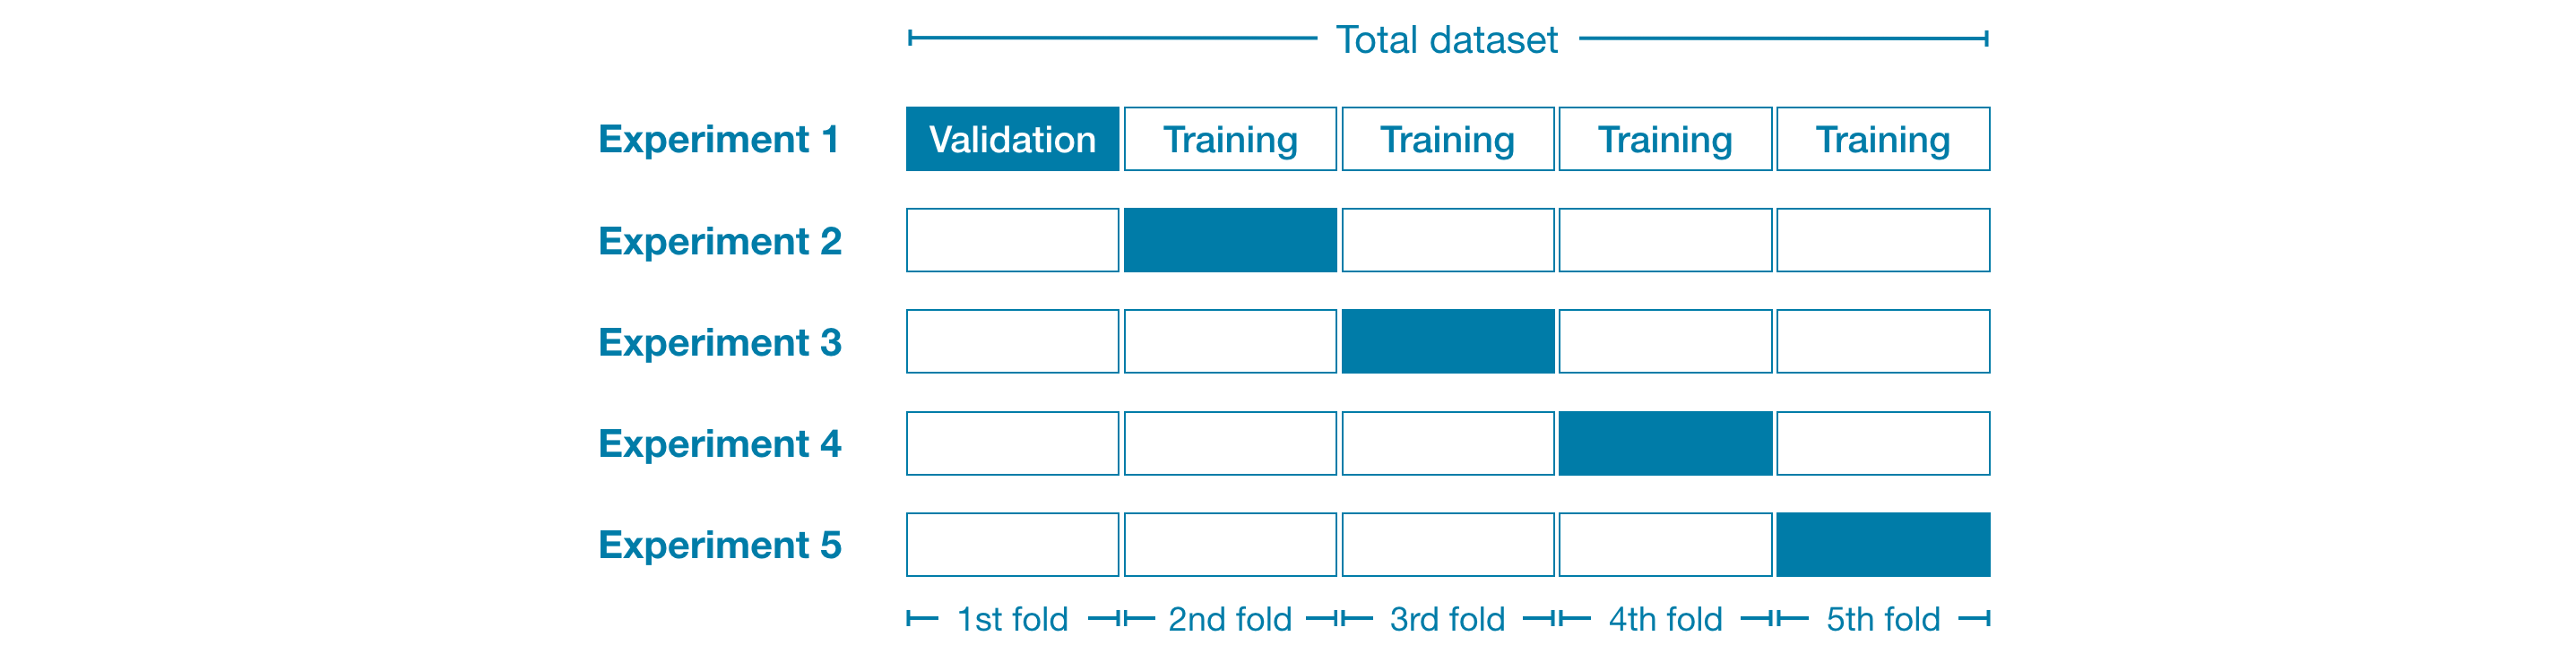

    Em seguida, executamos um experimento para cada dobra:

    No Experimento 1, usamos a primeira fold como um conjunto de validação (ou validação) e todo o resto como dados de treinamento. Isso nos dá uma medida da qualidade do modelo com base em um conjunto de 20% de validação.
    
    No Experimento 2, mantemos os dados da segunda fold (e usamos tudo, exceto a segunda fold, para treinar o modelo). O conjunto de validação é então usado para obter uma segunda estimativa da qualidade do modelo.
    
    Repetimos esse processo, usando cada fold uma vez como o conjunto de retenção. Juntando isso, 100% dos dados são usados como validação em algum momento e acabamos com uma medida de qualidade do modelo baseada em todas as linhas do conjunto de dados (mesmo que não usemos todas as linhas simultaneamente).
    
    A pergunta final é: QUANDO deveremos utilizar cross-validation?
    1. Para small datasets, onde a carga computacional não é um grande problema, você deve priorizar a utilização do cross-validation.
    2. Para conjuntos de dados maiores, um único conjunto de validação é suficiente. Seu código será executado mais rápido e você pode ter dados suficientes para que haja pouca necessidade de reutilizar alguns deles para validação. 
    3. Se tiver tempo, de forma alternativa poderá rodar com cross-validation e avaliar se os scores para cada experimento estão próximos. Se resultar no mesmo score, use a validação simples que é suficiente

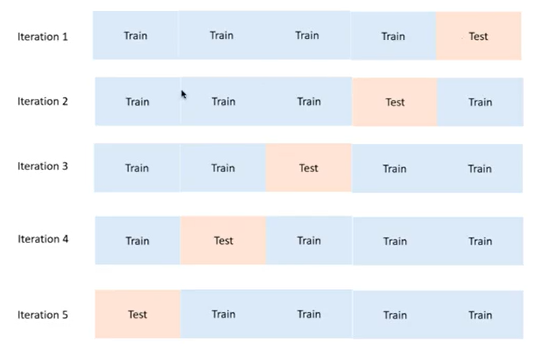

**Exemplo 01:** 

    Em seguida, definimos um pipeline que usa um imputador para preencher os valores ausentes e um modelo de floresta aleatória para fazer previsões.
    Embora seja possível fazer validação cruzada sem pipelines, é bastante difícil! Usar um pipeline tornará o código notavelmente direto.
    

In [17]:
import pandas as pd

# Read the data
data = pd.read_csv('melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Select target
y = data.Price

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))])

In [19]:
from sklearn.model_selection import cross_val_score

# Código: Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [301628.7893587  303164.4782723  287298.331666   236061.84754543
 260383.45111427]


In [20]:
#Média dos resultados da 05 execuções (cv = 5) via cross-validation = Acurácia do modelo

print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
277707.3795913405


In [21]:
# Código em forma de função
def get_score(n_estimators):
    my_pipeline = Pipeline(steps=[
        ('preprocessor', SimpleImputer()),
        ('model', RandomForestRegressor(n_estimators, random_state=0))])
    
    scores = -1 * cross_val_score(my_pipeline, X, y,
                                  cv=3,
                                  scoring='neg_mean_absolute_error')
    return scores.mean()

In [22]:
# Código de cross-validation [Canal ciência dos dados]:
#Definindo os valores para os folds
#num_fols = 10
#seed = 7

#Separando os dados em folds
#kfold = KFold(num_folds, True, random_state = seed)

#Criando o modelo
#modelo = LogisticRegression()
#resultado = cross_val_score(modelo, X, Y, cv = kfold) #treino e teste cross validados e executados de uma vez só.

# Usando média e o desvio padrão
#print ('Acurácia Final: %.3f%%' % (resultado.mean() * 100))

**Conclusion**:
    
    Cross validation é basicamente uma técnica para avaliar a perfomance de um modelo com menos variância que a técnica em dividir os dados em treino/teste. Com essa técnica dividimos os dados em partes chamadas de 'k-folds' (k = 5, k = 10...). Cada parte é chamada de fold. O algoritmo é treinado em k-1 folds. Cada fold é usado no treinamento de forma repetida e um fold por vez, após executar todos os folds, podemos sumarizar a perfomance em cada fold usando a média e o desvio padrão, oferecendo maior acurácia ao modelo. A chave deste processo está em definir o correto valor de k, d emodo que o número de folds represente adquadamento o número de repetições necessárias.

    Using cross-validation yields a much better measure of model quality, with the added benefit of cleaning up our code: note that we no longer need to keep track of separate training and validation sets. So, especially for small datasets, it's a good improvement!

# XGBoost


        Para entender o XGBoost é necessário entender como funciona o Gradient Boosting.
 

## Introdução
        O grande objetivo deste tutotal é como criar e otimizar modelos utilizando gradient boosting.
        
        Durante grande parte deste curso, você fez previsões com o método de floresta aleatória, que alcança melhor desempenho do que uma única árvore de decisão simplesmente pela média das previsões de muitas árvores de decisão.Referimo-nos ao método da floresta aleatória como um "ensemble method". Por definição, os ensemble methods combinam as previsões de vários modelos (por exemplo, várias árvores, no caso de florestas aleatórias).
        
        Gradiente Boost é um modelo que funciona através de ciclos interativos que adiciona os modelos em ensembles.
        Inicia o ensemble com um único modelo, em que as previsões podem ser bastante ingênuas. (Mesmo que suas previsões sejam extremamente imprecisas, adições subsequentes ao conjunto resolverão esses erros). Assim, se inicia os círculos:
        
    - Primeiro, usamos o conjunto atual para gerar previsões para cada observação no conjunto de dados. Para fazer uma previsão, adicionamos as previsões de todos os modelos no conjunto.
    - Essas previsões são usadas para calcular uma loss function (como erro quadrático médio, por exemplo).
    - Em seguida, usamos a loss function para fitar um novo modelo que será adicionado ao ensemble. Especificamente, determinamos os parâmetros do modelo para que a adição desse novo modelo ao conjunto reduza a perda. (Nota: O "gradiente" em "aumento de gradiente" refere-se ao fato de que usaremos gradiente descendente na função de perda para determinar os parâmetros neste novo modelo.)
    - Por fim, adiciona esse novo modelo ao ensemble e...repete!
    
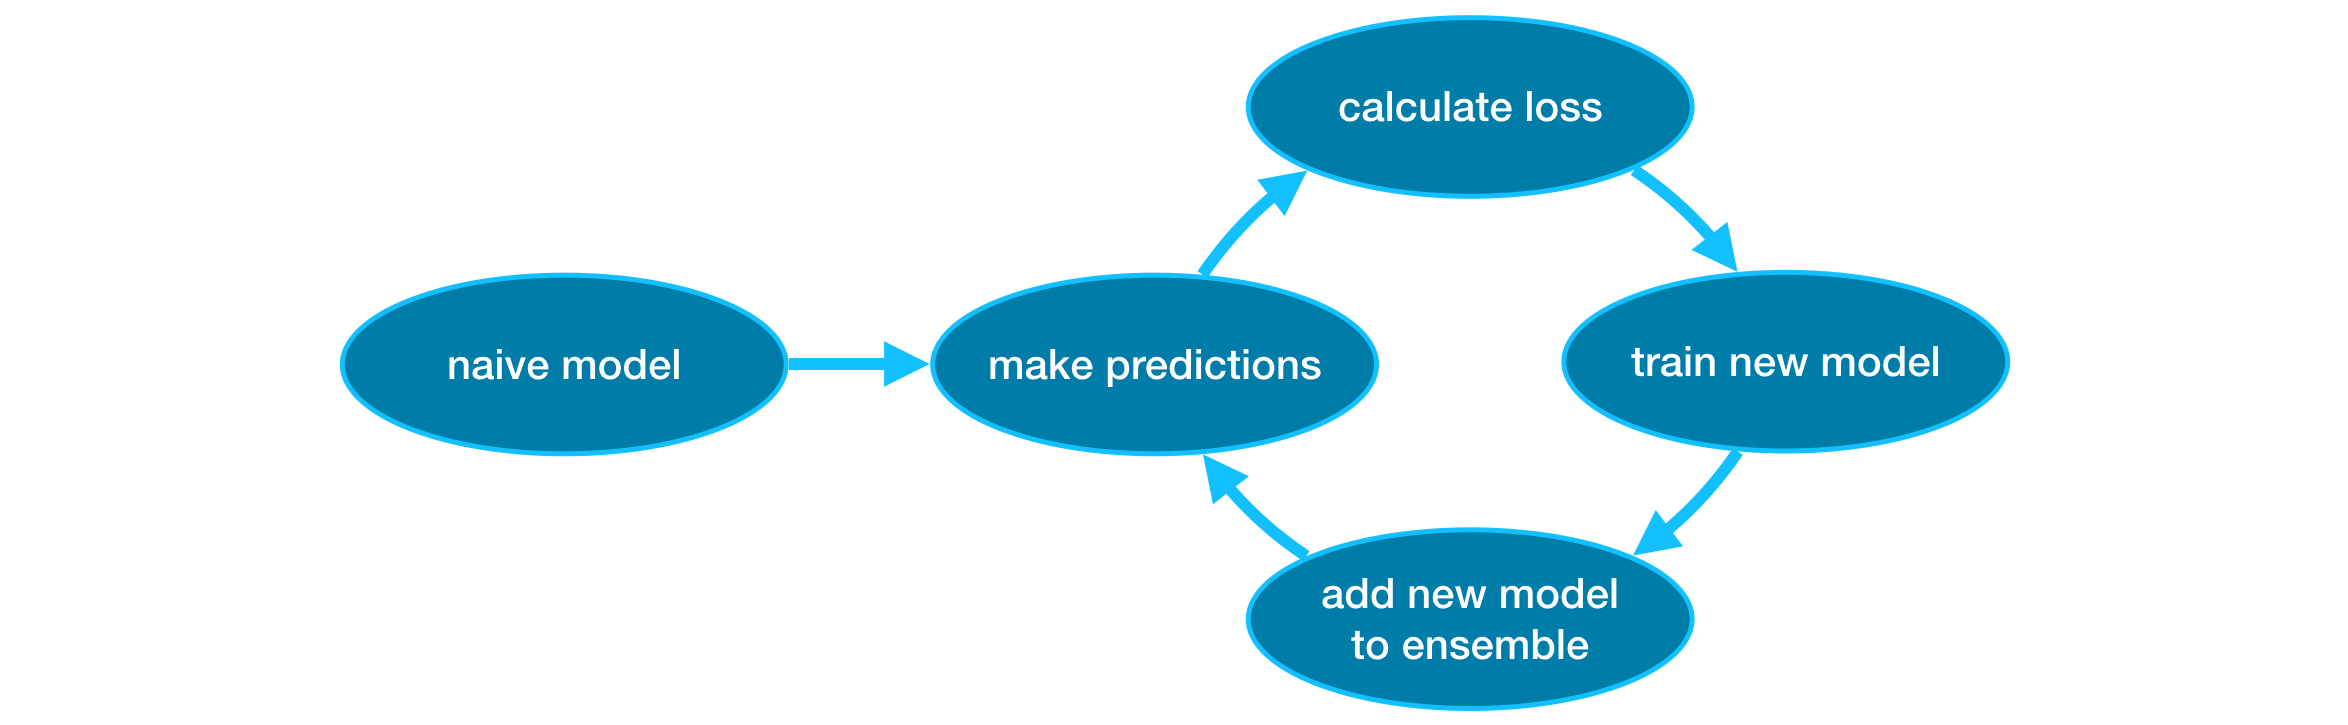
        

**Exemplo:** Nesse exemplo utilizaremos XGBoost library. XGBoost significa Extreme gradiente boosting, que é uma implementação ao gradiente boosting com várias adições de features focadas em perfomance e velocidade. 

    Na próxima célula de código, importamos a API scikit-learn para XGBoost (xgboost.XGBRegressor). Isso nos permite construir e ajustar um modelo exatamente como faríamos no scikit-learn. Como você verá na saída, a classe XGBRegressor tem muitos parâmetros ajustáveis,você aprenderá sobre eles em breve!

In [23]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Select target
y = data.Price

# Separate data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [24]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
my_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [25]:
from sklearn.metrics import mean_absolute_error

predictions = my_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 249720.69943391017


**Alguns paramêtros para tunar XGBoost**:
**1. n_estimators:** 

    o n_estimators especifica quantas vezes o modelo irá passar pelos ciclos. É igual ao número de modelos que incluiremos in the ensemble. 

    1.1 Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
    
    1.2 Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about)

    Typical values range from 100-1000, though this depends a lot on the learning_rate parameter discussed below.
    
            Obs: quanto maior o nº de árvores no XGBoost, menor será a learning_rate necessária. Basicamente é uma média ponderada das previsões das árvores, só que treinadas na diferença do que as árvores anteriores erraram (Boosting é a ideia de treinar sequencialmente baseado nos erros anteriores).


**2. early_stopping_round:**
       
       Early_stopping_rounds oferece uma maneira de encontrar automaticamente o valor ideal para n_estimators. A interrupção antecipada faz com que o modelo pare de iterar quando a pontuação de validação para de melhorar, mesmo que não estejamos na parada difícil para n_estimators. É inteligente definir um valor alto para n_estimators e, em seguida, usar early_stopping_rounds para encontrar o momento ideal para interromper a iteração.

    Como a chance aleatória às vezes causa uma única rodada em que as pontuações de validação não melhoram, você precisa especificar um número para quantas rodadas de deterioração direta permitir antes de parar. Definir early_stopping_rounds=5 é uma escolha razoável. Nesse caso, paramos após 5 rodadas consecutivas de deterioração das pontuações de validação.

    Ao usar early_stopping_rounds, você também precisa separar alguns dados para calcular as pontuações de validação - isso é feito definindo o parâmetro eval_set.

    O código é o seguinte:
    my_model = XGBRegressor(n_estimators=500) #If you want to fit a model with all of your data, set n_estimators to any
                                              #value you found to be optimal when run with wearly stopping.
    my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

    

**3. learning_rate:**
    
    Em vez de obter previsões simplesmente somando as previsões de cada modelo de componente, podemos multiplicar as previsões de cada modelo por um pequeno número (conhecido como 'taxa de aprendizado') antes de adicioná-las.

    Isso significa que cada árvore que adicionamos ao conjunto nos ajuda menos. Assim, podemos definir um valor mais alto para n_estimators sem overfitting. Se usarmos a parada antecipada, o número apropriado de árvores será determinado automaticamente.

   **Em geral, uma pequena taxa de aprendizado (learning_rate) e um grande número de estimadores (n_estimators) produzirão modelos XGBoost mais precisos**, embora também leve mais tempo para treinar o modelo, pois faz mais iterações ao longo do ciclo. Como padrão, o XGBoost define learning_rate=0.1.

    Modificar o exemplo acima para alterar a learning rate gera o seguinte código:
    
    my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
    my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)
    

**4. n_jobs:**
    
    Em conjuntos de dados maiores em que o tempo de execução é uma consideração, você pode usar o paralelismo para criar seus modelos mais rapidamente. É comum definir o parâmetro n_jobs igual ao número de núcleos em sua máquina. Em conjuntos de dados menores, isso não ajudará.

    O modelo resultante não será melhor, então a micro-otimização para o tempo de adaptação normalmente não passa de uma distração. Mas é útil em grandes conjuntos de dados onde você gastaria muito tempo esperando durante o comando fit.
    
    my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
    my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)
    

# Data Leakage
    Encontre e corrija esse problema que arruina o modelo de formas sutis. Neste tutorial, você aprenderá o que é vazamento de dados e como evitá-lo. Se você não souber como evitá-lo, o vazamento surgirá com frequência e arruinará seus modelos de maneiras sutis e perigosas. Portanto, esse é um dos conceitos mais importantes para a prática de cientistas de dados.

## Introdução:
     Data Leakage ou vazamento de dados ocorre quando seus dados de treinamento contêm informações sobre o destino, mas dados semelhantes não estarão disponíveis quando o modelo for usado para previsão. Isso leva a um alto desempenho no conjunto de treinamento (e possivelmente até nos dados de validação), mas o modelo terá um desempenho ruim na produção.

    Em outras palavras, o vazamento faz com que um modelo pareça preciso até que você comece a tomar decisões com o modelo, e então o modelo se torna muito impreciso.

    Existem dois tipos principais de vazamento: target leakage e train-test contamination.

**Target leakage:** 

    O vazamento de destino ocorre quando seus preditores incluem dados que não estarão disponíveis no momento em que você fizer previsões. É importante pensar no vazamento de destino em termos de tempo ou ordem cronológica em que os dados se tornam disponíveis, não apenas se um recurso ajuda a fazer boas previsões.

    Um exemplo será útil. Imagine que você queira prever quem ficará doente com pneumonia. As primeiras linhas de seus dados brutos são assim:
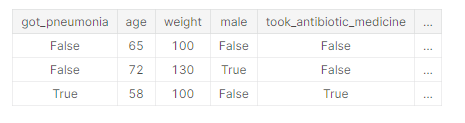

    As pessoas tomam medicamentos antibióticos depois de contrair pneumonia para se recuperar. Os dados brutos mostram uma forte relação entre essas colunas, mas take_antibiotic_medicine é frequentemente alterado depois que o valor de got_pneumonia é determinado. Este é o vazamento alvo.

    O modelo vai aprender que qualquer pessoa que tivesse um valor False para take_antibiotic_medicine não tinha pneumonia. Como os dados de validação vêm da mesma fonte que os dados de treinamento, o padrão se repetirá na validação e o modelo terá ótimas pontuações de validação (ou validação cruzada).

    Mas o modelo será muito impreciso quando implantado posteriormente no mundo real, porque mesmo os pacientes que terão pneumonia ainda não terão recebido antibióticos quando precisarmos fazer previsões sobre sua saúde futura.

    Para evitar esse tipo de vazamento de dados, qualquer variável atualizada (ou criada) após a realização do valor de destino deve ser excluída.

**Train-test Contamination:**

    Um tipo diferente de vazamento ocorre quando você não tem o cuidado de distinguir os dados de treinamento dos dados de validação.

    Lembre-se de que a validação deve ser uma medida de como o modelo se comporta em dados que ele não considerou antes. Você pode corromper esse processo de maneiras sutis se os dados de validação afetarem o comportamento de pré-processamento. Isso às vezes é chamado de contaminação de train-test contamination.
    
    Por exemplo, imagine que você executa o pré-processamento (como ajustar um imputer para valores ausentes) antes de chamar train_test_split(). O resultado final? Seu modelo pode obter boas pontuações de validação, dando a você grande confiança nele, mas apresentar um desempenho ruim quando você o implanta para tomar decisões.

    Afinal, você incorporou dados da validação ou dados de teste em como você faz previsões, portanto, pode se sair bem nesses dados específicos, mesmo que não possa generalizar para novos dados. Esse problema se torna ainda mais sutil (e mais perigoso) quando você faz engenharia de recursos mais complexa.

    Se sua validação for baseada em uma simples divisão de train-test split, exclua os dados de validação de qualquer tipo de ajuste, incluindo o ajuste de etapas de pré-processamento. 
    Isso é mais fácil se você usar pipelines scikit-learn. Ao usar validação cruzada, é ainda mais importante que você faça seu pré-processamento dentro do pipeline!